<a href="https://colab.research.google.com/github/jorisboeye/build_your_own_transformer/blob/main/Walkthrough_Attention_PyData_Global_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Explaining Attention Mechanism Step-by-Step**
### Speakers: [Sheetal Borar](https://https://www.linkedin.com/in/sheetal-borar/), [Chuxin Liu](https://www.linkedin.com/in/chuxin-liu/), [Shefali Shrivastava](https://www.linkedin.com/in/shefali-shrivastava-120b02bb/)

In this notebook, we will break down the attention mechanism as described in the paper **[Attention Is All You Need](https://arxiv.org/abs/1706.03762)** step by step using NumPy. By the end of this walkthrough, you will have a clear understanding of what attention is, how to calculate it step by step, and how it works in practice.


In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True) # set a print option to 4 decimal places

##Step 1: Create Embeddings for Words

The first step is to turn each word in our sentence [you, are, amazing] into a set of numbers.

- For simplicity, we'll assume that word embeddings are vectorized in an 8-dimensional space. We'll use 8-dimensional numerical representation to describe each word (in real transformers, they use 512 dimensions!). Each word gets assigned random numbers at first. Therefore, embedding size is set to 8 and a random vector for each word is generated using `np.random.rand` function.

Context:
- Word embeddings help the computer understand words by representing them as lists of numbers. While they start as random numbers, during training these numbers will be adjusted so that words with similar meanings get similar numbers.
- Essentially, transformers learn to assign weights to word embeddings and use attention mechanisms to focus on relevant parts of the input. This helps them understand context and predict the most likely next word in a sequence.

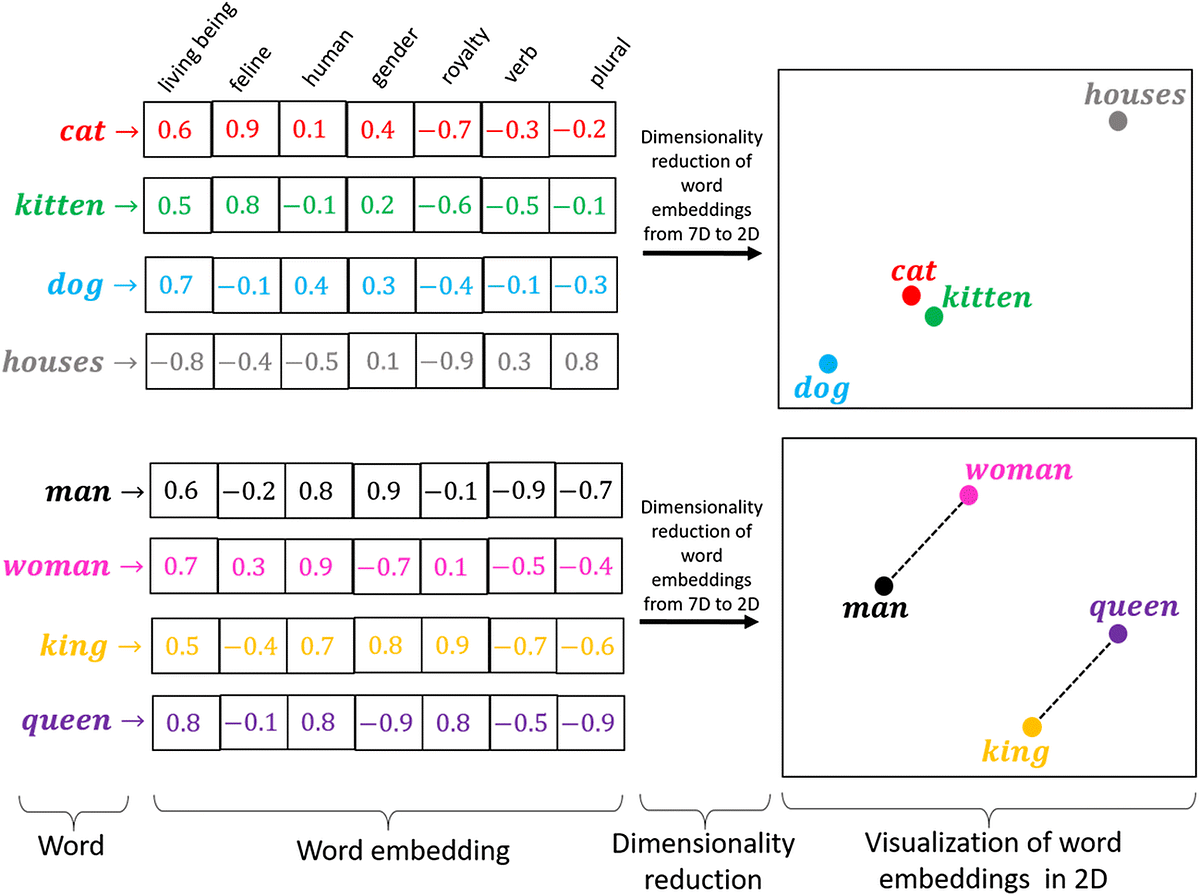

In [3]:
# Define embedding dimension
embedding_dim = 8

# Randomly initialize word embeddings of size [embedding_dim]
np.random.seed(42)  # For reproducibility
words = ["you", "are", "amazing"]
word_embeddings = {word: np.random.rand(embedding_dim) for word in words}

print(f"Word Embedding shape: {word_embeddings['amazing'].shape}")
print(f"Word Embedding for 'amazing': {word_embeddings['amazing']}")

Word Embedding shape: (8,)
Word Embedding for 'amazing': [0.3042 0.5248 0.4319 0.2912 0.6119 0.1395 0.2921 0.3664]



- We will also add positional embedding to the vector. Positional embeddings encode the relative position of tokens in a sequence and are added to word embeddings for computational efficiency and dimensional consistency. Generally, positional embeddings are added to word vector (and not appended) for computational efficiency. The paper uses sine and cosine functions of different frequencie to add encodings.

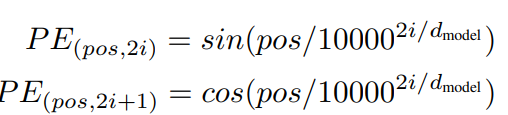


In [4]:
# Define function to generate positional encoding for each index and dim
def positional_encoding(position, dim):
    angle_rates = 1 / np.power(10000, (2 * (np.arange(dim) // 2)) / np.float32(dim))
    encoding = np.zeros(dim)
    encoding[0::2] = np.sin(position * angle_rates[0::2])  # Even
    encoding[1::2] = np.cos(position * angle_rates[1::2])  # Odd
    return encoding

# Add positional encodings to each word embedding
positions = {'you': 0, 'are': 1, 'amazing': 2}
for word, position in positions.items():
    pos_encoding = positional_encoding(position, embedding_dim)
    word_embeddings[word] += pos_encoding

# Print results
print(f"Word Embedding shape: {word_embeddings['amazing'].shape}")
print(f"Word Embedding for 'amazing' with positional encoding: {word_embeddings['amazing']}")

Word Embedding shape: (8,)
Word Embedding for 'you' with positional encoding: [1.2135 0.1086 0.6306 1.2713 0.6319 1.1393 0.2941 1.3664]


## Step 2. Stack Word Embeddings into an Input Matrix

In this step:

- We stack the word embeddings into a single matrix $X$, where each row corresponds to a word in the sentence.

Context: This will serve as the input to the attention mechanism.

In [7]:
# Input matrix (stacked embeddings)
X = np.vstack(list(word_embeddings.values()))

seq_len = X.shape[0]

print(f"\nSequence length: {seq_len}")
print(f"\nInput Matrix (X) shape:{X.shape}") #Size: seq_len x embedding_dim
print(f"\nInput Matrix (X):\n{X}")


Sequence length: 3

Input Matrix (X) shape:(3, 8)

Input Matrix (X):
[[0.3745 1.9507 0.732  1.5987 0.156  1.156  0.0581 1.8662]
 [1.4426 1.2484 0.1204 1.9649 0.8424 1.2123 0.1828 1.1834]
 [1.2135 0.1086 0.6306 1.2713 0.6319 1.1393 0.2941 1.3664]]


**Introducing Query, Key and Value!**


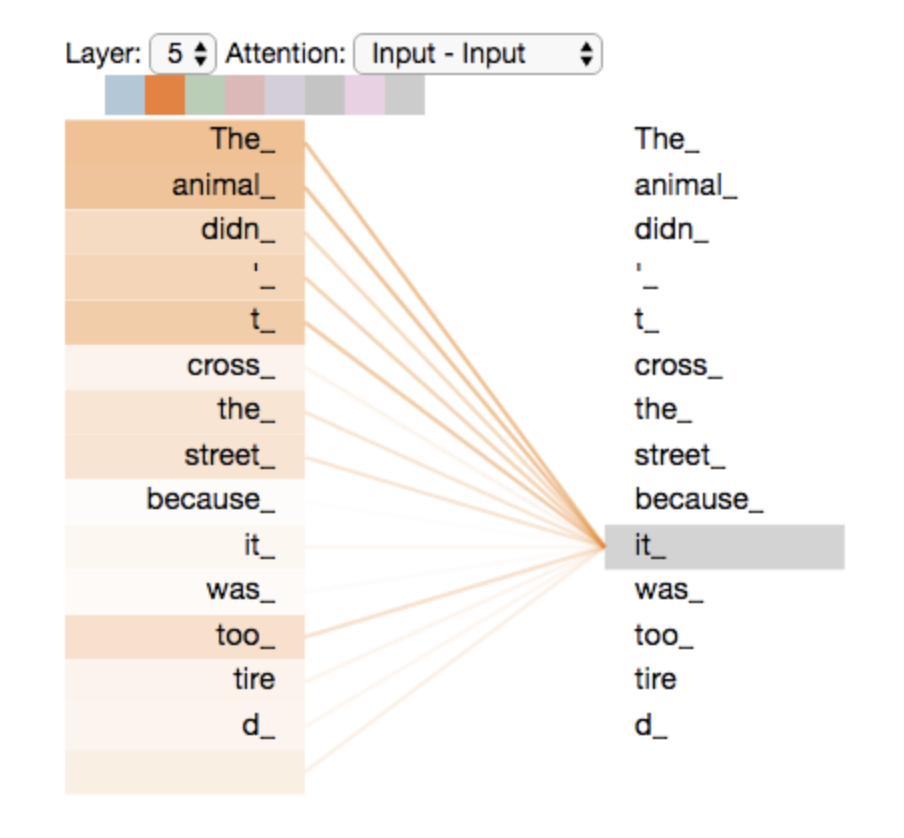

Query (for the word **"it"**): When processing **"it"**, the query is asking "What does **'it'** refer to?"

Keys and Values:
1. **"animal"**:
- Key: information about being the subject, a living being, capable of being tired
- Value: information about being the main actor in this context (the one making the decision)
2. **"street"**:
- Key: information about being an object, a location, something to be crossed
- Value: information about being a path or obstacle in this context
3. **"tired"**:
- Key: information about being a state/condition that affects living beings
- Value: information about fatigue/exhaustion

When the query for **"it"** compares with all keys, it finds very strong alignment with **"animal"**'s key because:

- **"animal"** is the subject of the sentence
- Only living beings can be **"tired"**
- The grammar and structure suggest **"it"** refers to the subject
- There's a logical connection between being tired and not taking an action

It finds very weak alignment with **"street"**'s key because:
- A street is an inanimate object
- Streets can't be **"tired"**
- The grammar makes this connection illogical

To summarize:

1. Query (What are we looking for?)

2. Key (What is this word about?)

3. Value (What useful information should be gathered?)

In transformers, key, value, and query are central to the self-attention mechanism. Self-attention tries to find out which words closely relate to which other words in a sequence by using the mechanism above.


## Step 3. Create Weight Matrices for Q, K, V

In this step:

- Randomly initialize three weight matrices for Query, Key and Value, using `np.random.rand` function: $W_{q}$, $W_{k}$, and $W_{v}$.

- Weight matrices have dimensions `embedding_dim x head_dim` (8 x 8). `head_dim = embedding_dim / (number of heads)`. `head_dim` is the dimension of each head.

Context:
- $W_{q}$ is used to compute the query vector $Q$, $W_{k}$ is used to compute the key vector $K$, $W_{v}$ is used to compute the value vector $V$.
- $Q$, $K$ and $V$ are transformations of the X (input vectors).
- Since we're working with a single attention head in this example, `head_dim = embedding_dim`. However, in the original paper, the Q, K, and V matrices are based on `head_dim` and `number of heads` is 8.Hence, each head has the dimension size (`head_dim`) 64 (512/8).

In [9]:
head_dim = embedding_dim # single head

# Randomly initialize weight matrices for Q, K, V
W_q = np.random.rand(embedding_dim, head_dim) # Shape (embedding_dim, head_dim)
W_k = np.random.rand(embedding_dim, head_dim)
W_v = np.random.rand(embedding_dim, head_dim)

print("\nRandomly Initialized Weight Matrices:")
print(f"W_q:\n{W_q}")
print(f"W_k:\n{W_k}")
print(f"W_v:\n{W_v}")
print("\n")
print(f"Shape of W_q, W_k, W_v:\n{W_q.shape},\n{W_k.shape},\n{W_v.shape}")


Randomly Initialized Weight Matrices:
W_q:
[[0.4561 0.7852 0.1997 0.5142 0.5924 0.0465 0.6075 0.1705]
 [0.0651 0.9489 0.9656 0.8084 0.3046 0.0977 0.6842 0.4402]
 [0.122  0.4952 0.0344 0.9093 0.2588 0.6625 0.3117 0.5201]
 [0.5467 0.1849 0.9696 0.7751 0.9395 0.8948 0.5979 0.9219]
 [0.0885 0.196  0.0452 0.3253 0.3887 0.2713 0.8287 0.3568]
 [0.2809 0.5427 0.1409 0.8022 0.0746 0.9869 0.7722 0.1987]
 [0.0055 0.8155 0.7069 0.729  0.7713 0.074  0.3585 0.1159]
 [0.8631 0.6233 0.3309 0.0636 0.311  0.3252 0.7296 0.6376]]
W_k:
[[0.8872 0.4722 0.1196 0.7132 0.7608 0.5613 0.771  0.4938]
 [0.5227 0.4275 0.0254 0.1079 0.0314 0.6364 0.3144 0.5086]
 [0.9076 0.2493 0.4104 0.7556 0.2288 0.077  0.2898 0.1612]
 [0.9297 0.8081 0.6334 0.8715 0.8037 0.1866 0.8926 0.5393]
 [0.8074 0.8961 0.318  0.1101 0.2279 0.4271 0.818  0.8607]
 [0.007  0.5107 0.4174 0.2221 0.1199 0.3376 0.9429 0.3232]
 [0.5188 0.703  0.3636 0.9718 0.9624 0.2518 0.4972 0.3009]
 [0.2848 0.0369 0.6096 0.5027 0.0515 0.2786 0.9083 0.2396]]
W_v:


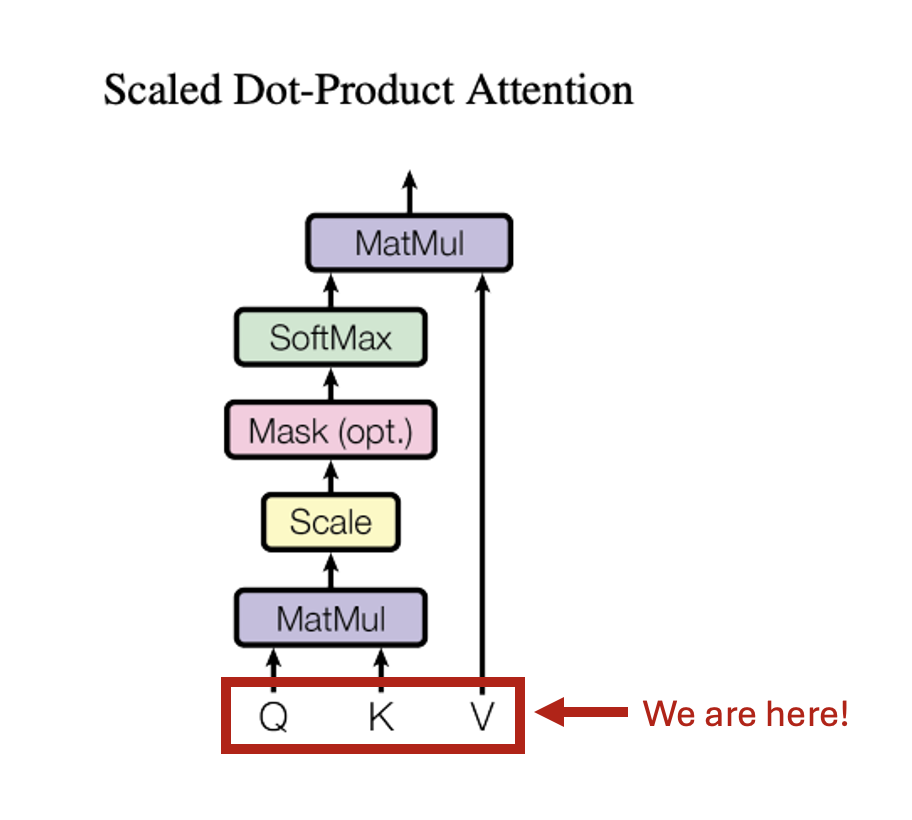

## Step 4. Compute Query ($Q$), Key ($K$), and Value ($V$) Matrices

In this cell:

- Compute the $Q$, $K$, and $V$ matrices doing a dot product between $X$ and the $W$ matrix, use ```np.dot``` function:
- $Q$ = $X$⋅$W_{q}$
- $K$ = $X$⋅$W_{k}$
- $V$ = $X$⋅$W_{v}$

Dimensions of Q, K and V matrices: `seq_len x head_dim`

Remember, `head_dim = embedding_dim` as we are working with only one head.



In [10]:
# Compute Q, K, V
Q = np.dot(X, W_q)
print(f"\nQuery Matrix (Q):\n{Q}")

K = np.dot(X, W_k)
print(f"\nKey Matrix (K):\n{K}")

V = np.dot(X, W_v)
print(f"\nValue Matrix (V):\n{V}")


Query Matrix (Q):
[[3.2106 4.6715 4.3622 4.8134 3.2794 3.9177 5.1507 4.2588]
 [3.2656 4.4498 4.1326 4.8386 4.0389 3.8503 5.5063 3.9866]
 [2.8894 3.4368 2.4507 3.6915 3.0919 3.3843 4.2741 3.1117]]

Key Matrix (K):
[[4.1983 3.3252 3.0982 3.6923 2.1246 2.7978 5.4825 3.1297]
 [4.9891 4.3791 3.06   4.1014 3.3176 3.1249 6.2913 3.8818]
 [3.9476 3.2093 2.8283 3.7569 2.7267 2.1453 5.2656 2.7697]]

Value Matrix (V):
[[3.034  3.6074 5.1513 3.2015 3.5217 3.7557 5.0402 3.6896]
 [3.4629 3.8557 5.9133 3.1644 4.0228 3.9501 4.6531 5.1316]
 [2.5045 2.9097 4.583  2.4956 3.8129 2.7861 3.9781 4.104 ]]


Hooray! Now we have our $Q$, $K$ and $V$vectors!


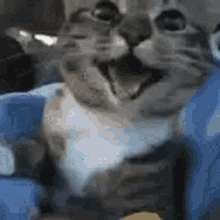

## Step 5. Calculate Attention Scores
In this cell:

* Compute the raw attention scores by taking the dot product of queries $Q$ and keys $K$ (transposed) using the formula provided below, use ```np.dot``` function:
  * $score = Q⋅K^{T}$

Context:
- This step involves doing a dot product of the query vector of one word with the key vector of each word.
- The resulting scores tell us how related each word is to the others in the sentence, indicating the level of attention that should be given to each word based on the current word's query.





In [12]:
scores = np.dot(Q, K.T)

print(f"\nAttention Scores (QK^T):\n{scores}")
print(f"\nShape of Attention Scores matrix:{scores.shape}")


Attention Scores (QK^T):
[[119.7964 141.6248 114.3513]
 [121.1941 143.8183 116.3466]
 [ 93.9901 111.9071  90.0504]]

Shape of Attention Scores matrix:(3, 3)


The shape of the score matrix is (3,3) because we have calculated the attention of each word with respect to itself and every other word in the sentence.

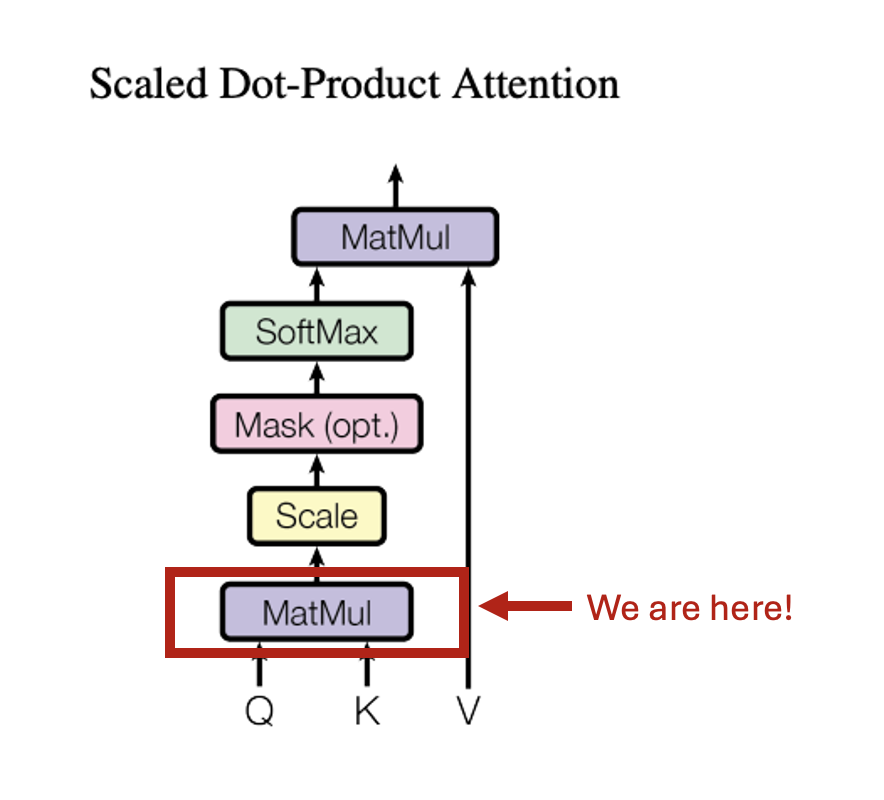

## Step 6. Scale Attention Scores
In this cell:

* Explore the shape of $K$ to understand what should the value of $d_{K}$ be. $d_{K}$ is the dimension of the $K$ vector.
* Scale the attention scores by dividing them by $\sqrt{d_{K}}$. Use ```np.sqrt``` function to calculate the square root of $d_{K}$

Context:
- This scaling forces variance to be 1 and helps prevent excessively large values in the softmax computation, ensuring numerical stability and allowing balanced attention.
- As shown in the softmax graph below, very large values can cause the output to concentrate towards either 0 or 1. Scaling prevents excessively sharp softmax probabilities and ensures effective training

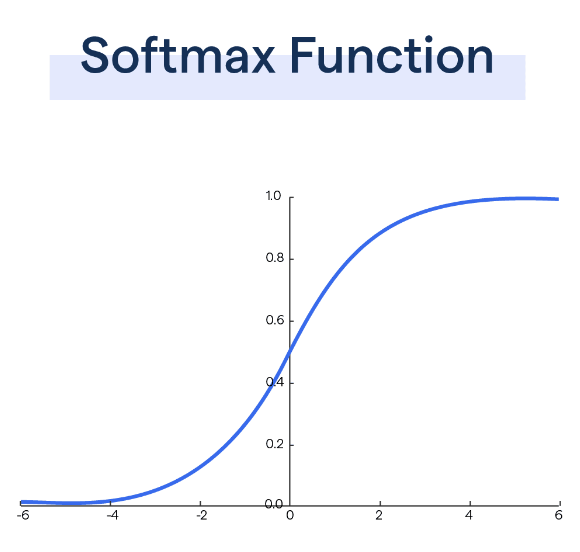

In [16]:
# Scale scores by sqrt(d_k)
d_k = K.shape[1]

scaled_scores = scores / np.sqrt(d_k)

print(f"\nd_k (dimension of the K matrix):{d_k}")
print(f"\nScaled Attention Scores:\n{scaled_scores}")
print(f"\nShape of Scaled Attention Scores:{scaled_scores.shape}")


d_k (dimension of the K matrix):8

Scaled Attention Scores:
[[42.3544 50.0719 40.4293]
 [42.8486 50.8474 41.1347]
 [33.2305 39.5651 31.8376]]

Shape of Scaled Attention Scores:(3, 3)


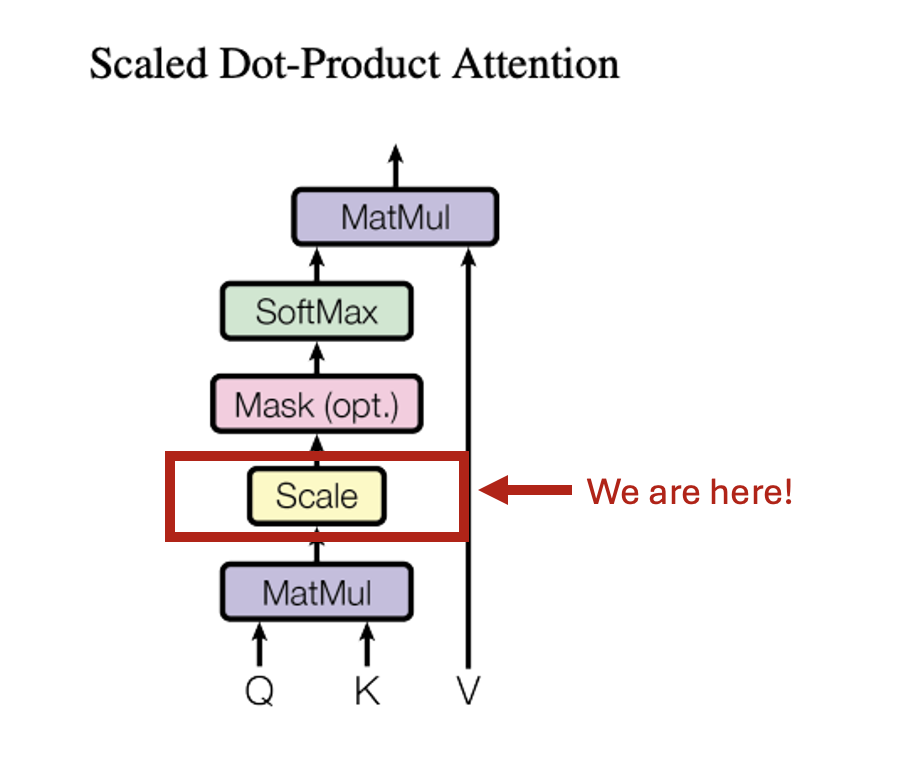

## Step 7. Add Attention Mask
In this cell:
- Create a 3×3 mask matrix where lower triangle is 0 and upper triangle is -inf
- use ```np.triu```  (triangular upper)  for quick generation


Context:
- Upper triangle is -inf to prevent attention to future words
- After softmax, -inf becomes 0, effectively blocking future information
- This is crucial for autoregressive (one word at a time) generation such that no future information is leaked during model training.

In [21]:
# Create a mask, upper right triangle set to -inf
mask = np.log(np.tri(3))

# Apply mask to attention scores
masked_scores = scaled_scores + mask  # adding -inf makes them 0 after softmax

# For reference, mask looks like:
print("Mask:\n", mask)
print("\n")
print("Masked Attention Scores\n", masked_scores)

Mask:
 [[  0. -inf -inf]
 [  0.   0. -inf]
 [  0.   0.   0.]]


Masked Attention Scores
 [[42.3544    -inf    -inf]
 [42.8486 50.8474    -inf]
 [33.2305 39.5651 31.8376]]


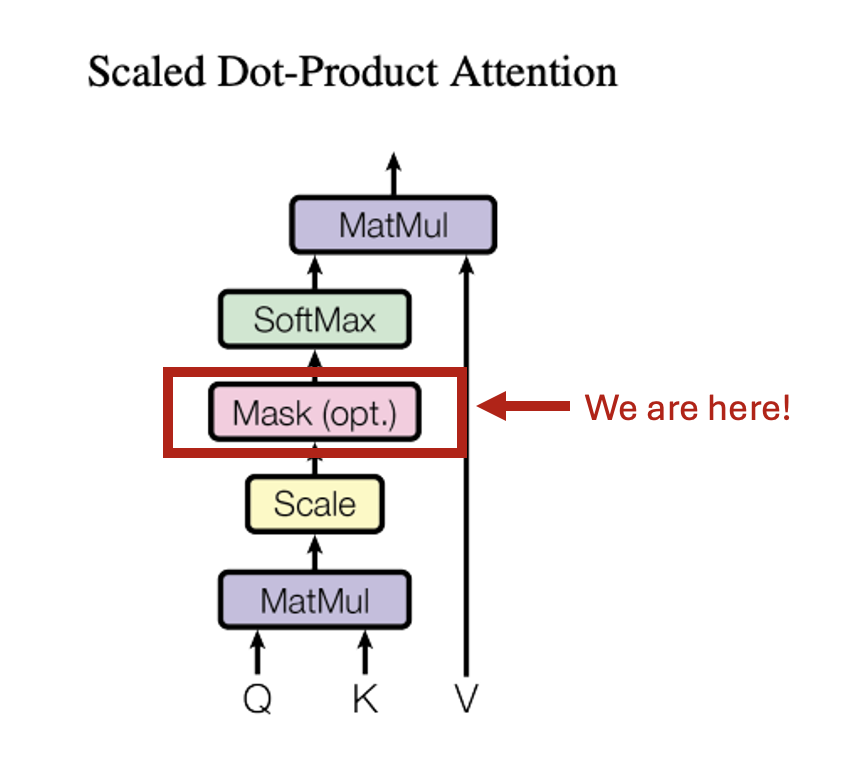

## Step 8. Apply Softmax to Compute Attention Weights

In this cell:

- Apply the softmax function to the scaled attention scores along the same dimension.
- The image below shows the formula of softmax. Use the ```np.exp``` function to calculate the natural log of the scaled scores.

Context:
- This converts the scores into probabilities between 0 and 1 (attention weights), which determine how much focus each word should receive.
- Print the attention weights for verification.

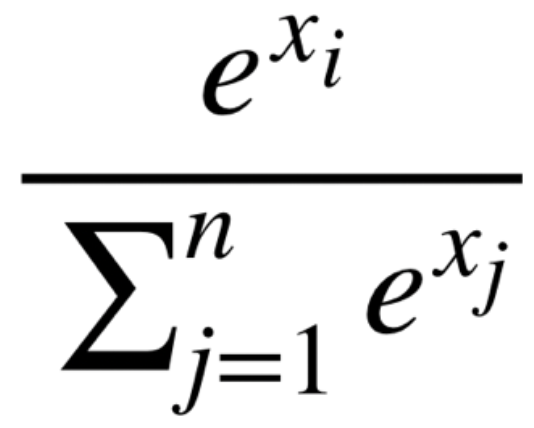

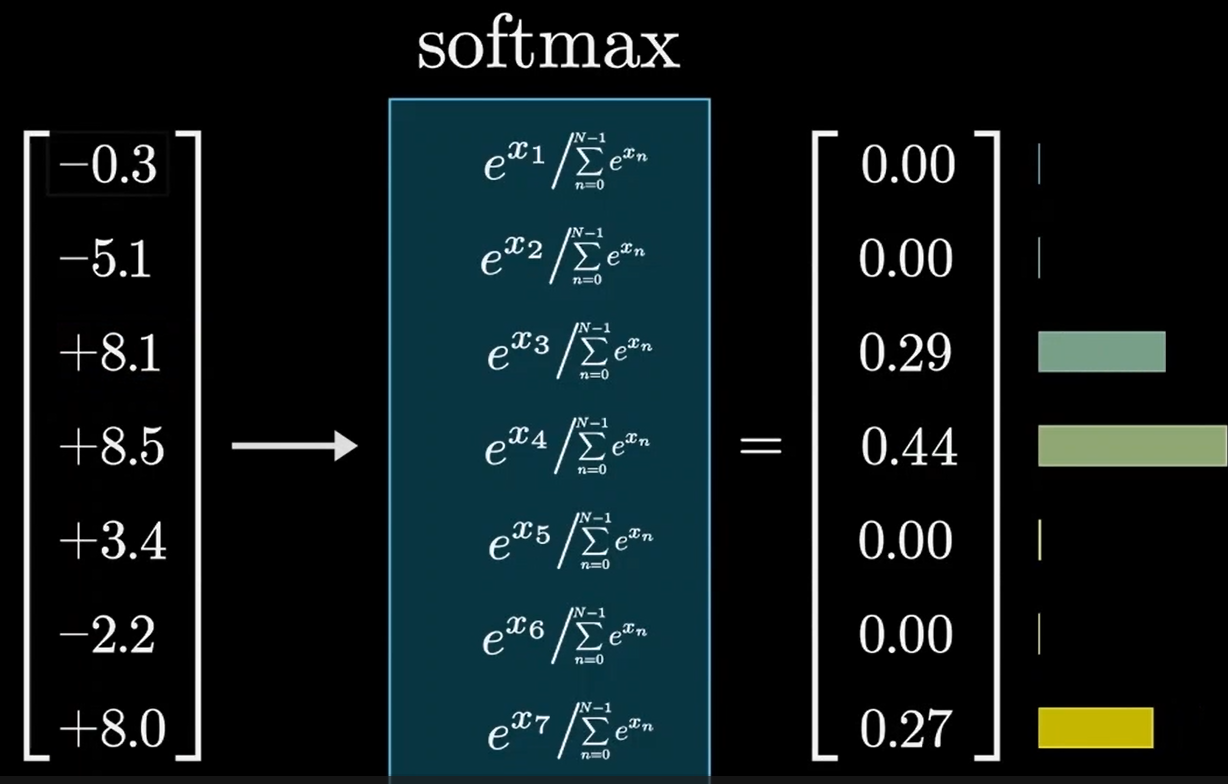

In [23]:
# Apply softmax to get attention weights
exp_scores = np.exp(masked_scores)

attention_weights = exp_scores / exp_scores.sum(axis=1, keepdims=True)
print(f"\nAttention Weights (softmax):\n{attention_weights}")


Attention Weights (softmax):
[[1.     0.     0.    ]
 [0.0003 0.9997 0.    ]
 [0.0018 0.9978 0.0004]]


- As you can see, the numbers in each row sum to 1, representing the probability of each word being related to every other word in the sentence.

- The below heatmap shows how each words attends to every other word more clearly.



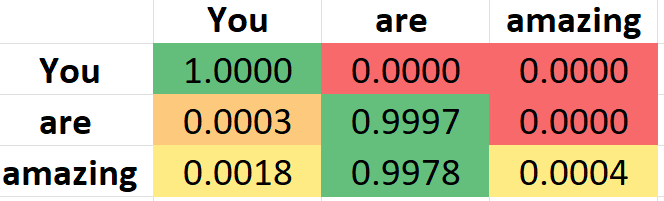

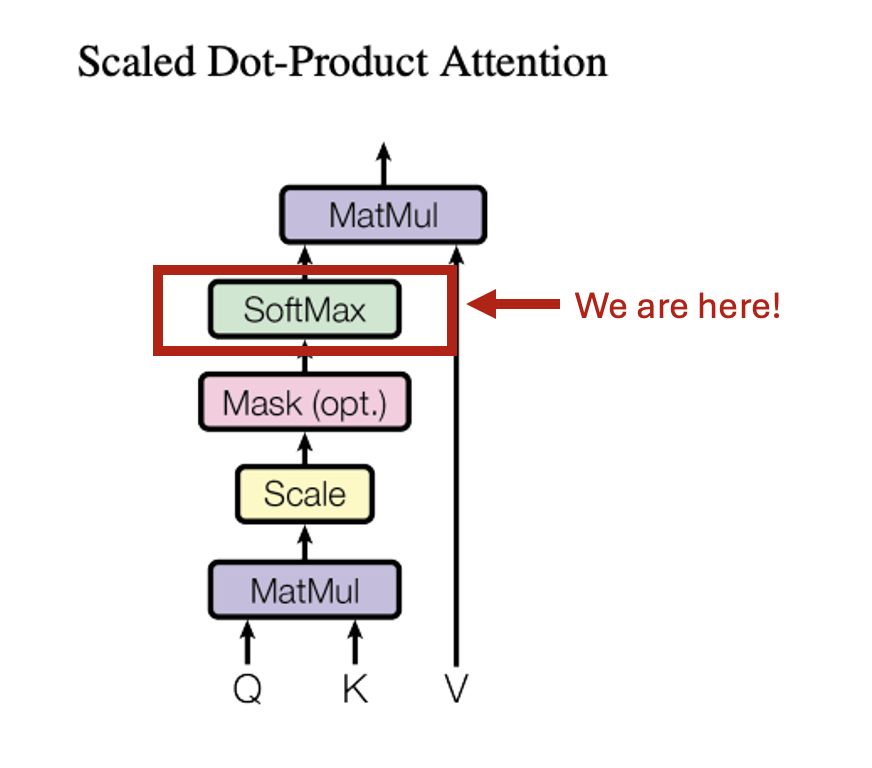

## Step 9. Compute Attention Output
In this cell:

* Use the attention weights to compute the output of the attention mechanism:
  * attention_output = attention_weights$⋅V$

**Context:**
- The output represents the attention scores applied on the value vectors of each word.
- By multiplying the attention weights by the value vectors, we essentially "weigh" the information from each word based on how relevant it is to the current word (as determined by the attention scores). This ensures that more relevant words have a larger influence on the final output.

In [25]:
# Compute attention output
attention_output = np.dot(attention_weights, V) # (3x3).(3x8)


print(f"\nShape of Attention Output:{attention_output.shape}")
print(f"\nAttention Output:\n{attention_output}") # dimension: seq_len x embedding_dim


Shape of Attention Output:(3, 8)

Attention Output:
[[3.034  3.6074 5.1513 3.2015 3.5217 3.7557 5.0402 3.6896]
 [3.4628 3.8556 5.9131 3.1644 4.0227 3.95   4.6532 5.1311]
 [3.4618 3.8548 5.9114 3.1642 4.0219 3.9492 4.6535 5.1286]]


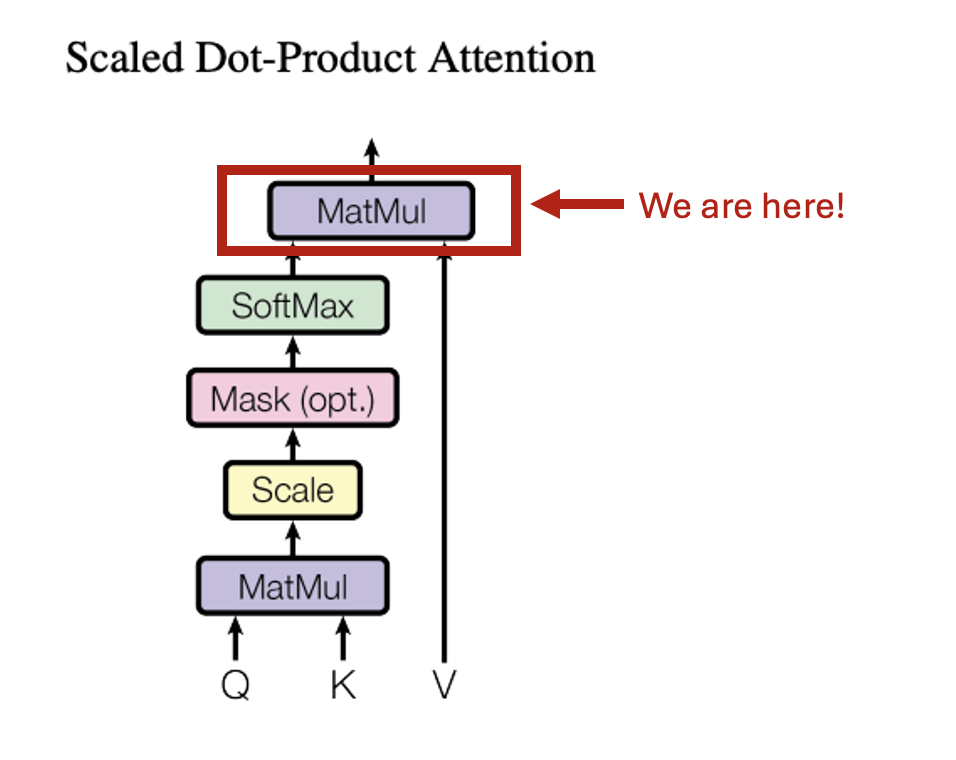

And..... we are done with attention!!

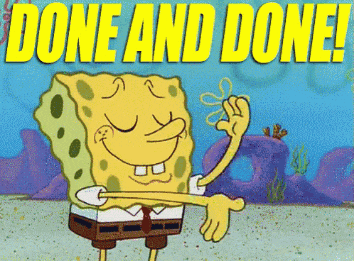

# Summary  
- An input matrix (X) was generated from the sentence *"you are amazing"* using random numerical embeddings and positional encoding, resulting in a matrix of size (`3 x 8`).  
- Attention scores were computed for a single attention head (`head_dim = 8`) by calculating query, key, and value matrices (`size: 3 x 8`).  
- Scaled attention scores were determined and used to weight the value matrix.  